<a href="https://colab.research.google.com/github/AMWBlock/AnthonyWilliams/blob/main/User_Behavior_Analysis_(Enhanced).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import io
import base64

# --- 1. Generate Sample User Log Data ---
# Create more realistic sample data
np.random.seed(42) # for reproducibility
num_logs = 1000
num_users = 100
users = [f'user_{i}' for i in range(num_users)]
pages = ['/home', '/products', '/products/item_a', '/products/item_b', '/cart', '/checkout', '/profile', '/about']
event_types = ['page_view', 'click_button', 'add_to_cart', 'purchase', 'search']

data = []
# Simulate data over a few days for DAU calculation
start_date = datetime(2024, 1, 1, 9, 0, 0)
end_date = start_date + timedelta(days=3) # Simulate 3 days of data
current_time = start_date

# Simulate sessions and events
user_last_event_time = {}
while current_time < end_date and len(data) < num_logs:
    user = np.random.choice(users)
    # Simulate time gaps between events (more realistic session structure)
    # Make gaps smaller if user was recently active
    last_time = user_last_event_time.get(user, current_time - timedelta(hours=1)) # Default to 1 hour ago if first event
    time_since_last = current_time - last_time
    # Generate smaller increments more often, larger increments less often
    time_increment_seconds = np.random.exponential(scale=120) + 1 # Average 2 minutes, min 1 sec
    time_increment = timedelta(seconds=time_increment_seconds)

    # Ensure time moves forward, handle multiple users potentially acting "simultaneously" in real time
    # Advance current_time based on the *next* event time for this user
    next_event_time = last_time + time_increment
    if next_event_time > current_time:
         current_time = next_event_time
    else:
        # If another user's event pushed current_time forward, use the later time
        next_event_time = current_time + timedelta(seconds=np.random.randint(1,5)) # Small increment if already behind
        current_time = next_event_time

    if current_time >= end_date: # Stop if we exceed the date range
        break

    user_last_event_time[user] = current_time # Update last event time for this user

    # Simulate different event types and details
    event_type = np.random.choice(event_types, p=[0.5, 0.2, 0.1, 0.05, 0.15]) # Probabilities
    event_details = None
    if event_type == 'page_view':
        # Make '/home' a more likely starting point
        if np.random.rand() < 0.4:
             event_details = '/home'
        else:
             event_details = np.random.choice(pages)
    elif event_type == 'click_button':
        event_details = np.random.choice(['buy_now', 'learn_more', 'submit_form', 'login'])
    elif event_type == 'add_to_cart':
        event_details = np.random.choice(['item_a', 'item_b', 'item_c']) # Example items
    elif event_type == 'purchase':
        event_details = f'order_{np.random.randint(1000, 9999)}'
    elif event_type == 'search':
        event_details = f'query_{np.random.choice(["shoes", "shirts", "gadgets", "books"])}'

    data.append({
        'user_id': user,
        'timestamp': current_time,
        'event_type': event_type,
        'event_details': event_details
    })

df = pd.DataFrame(data)

# Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort data for session calculation
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

print("--- Sample Data Head ---")
print(df.head())
print("\n--- Data Info ---")
df.info()
print(f"\nData spans from {df['timestamp'].min()} to {df['timestamp'].max()}")


# --- 2. Sessionization ---
# Define a session as a period of activity followed by inactivity (e.g., 30 minutes)
session_timeout = timedelta(minutes=30)

# Calculate time difference between consecutive events for each user
df['time_diff'] = df.groupby('user_id')['timestamp'].diff()

# Identify the start of a new session
df['new_session'] = (df['time_diff'] > session_timeout) | (df['time_diff'].isna())

# Assign a unique session ID to each session
df['session_id'] = df.groupby('user_id')['new_session'].cumsum()
df['global_session_id'] = df['user_id'] + '_' + df['session_id'].astype(str)

print("\n--- Data with Session IDs ---")
print(df.head())

# --- 3. Analysis ---

# a) Popular Features/Pages (based on page_view events)
print("\n--- Popular Pages (Page Views) ---")
popular_pages = df[df['event_type'] == 'page_view']['event_details'].value_counts()
print(popular_pages)

# b) Popular Event Types
print("\n--- Popular Event Types ---")
popular_events = df['event_type'].value_counts()
print(popular_events)

# c) Session Duration Analysis
session_durations = df.groupby('global_session_id')['timestamp'].agg(['min', 'max'])
session_durations['duration'] = session_durations['max'] - session_durations['min']
session_durations['duration_seconds'] = session_durations['duration'].dt.total_seconds()
print("\n--- Session Duration Stats ---")
print(session_durations['duration_seconds'].describe())
average_session_duration = session_durations['duration_seconds'].mean()
print(f"\nAverage Session Duration: {average_session_duration:.2f} seconds")

# d) Basic User Path Analysis (Example: Page View Transitions)
df_pages = df[df['event_type'] == 'page_view'].copy()
df_pages['next_page'] = df_pages.groupby('global_session_id')['event_details'].shift(-1)
page_transitions = df_pages.dropna(subset=['event_details', 'next_page'])
print("\n--- Common Page Transitions ---")
transition_counts = page_transitions.groupby(['event_details', 'next_page']).size().sort_values(ascending=False)
print(transition_counts.head(10)) # Display top 10 transitions

# e) Simple Conversion Funnel (Example: Home -> Products -> Cart -> Purchase)
print("\n--- Simple Conversion Funnel Analysis ---")
funnel_steps = {
    'step1_view_home': df[df['event_details'] == '/home']['user_id'].nunique(),
    'step2_view_products': df[df['event_details'] == '/products']['user_id'].nunique(),
    'step3_add_to_cart': df[df['event_type'] == 'add_to_cart']['user_id'].nunique(),
    'step4_purchase': df[df['event_type'] == 'purchase']['user_id'].nunique()
}
funnel_df = pd.DataFrame(list(funnel_steps.items()), columns=['Step', 'UniqueUsers'])
# Ensure UniqueUsers is numeric before calculations
funnel_df['UniqueUsers'] = pd.to_numeric(funnel_df['UniqueUsers'])
# Calculate conversion rates, handling potential division by zero if first step has 0 users
first_step_users = funnel_df['UniqueUsers'].iloc[0]
if first_step_users > 0:
    funnel_df['ConversionRate'] = (funnel_df['UniqueUsers'] / first_step_users) * 100
    funnel_df['StepConversionRate'] = (funnel_df['UniqueUsers'] / funnel_df['UniqueUsers'].shift(1).fillna(first_step_users)) * 100
    funnel_df.loc[0, 'StepConversionRate'] = 100.0
else:
    funnel_df['ConversionRate'] = 0.0
    funnel_df['StepConversionRate'] = 0.0

print(funnel_df)

# --- NEW ANALYSIS SECTIONS ---

# f) Daily Active Users (DAU)
print("\n--- Daily Active Users (DAU) ---")
# Extract date from timestamp
df['date'] = df['timestamp'].dt.date
# Group by date and count unique users
dau = df.groupby('date')['user_id'].nunique()
print(dau)
# Note: WAU/MAU would require grouping by week/month and need data spanning longer periods.

# g) Common Entry Pages
print("\n--- Common Entry Pages ---")
# Find the first event timestamp for each session
session_start_times = df.loc[df.groupby('global_session_id')['timestamp'].idxmin()]
# Filter for page view events that were the first event in a session
entry_page_views = session_start_times[session_start_times['event_type'] == 'page_view']
# Count the occurrences of each entry page
common_entry_pages = entry_page_views['event_details'].value_counts()
print(common_entry_pages)


# --- 4. Visualization ---
# Function to save plots to base64 strings for embedding
def plot_to_base64(plt):
    """Converts a matplotlib plot to a base64 encoded string."""
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight')
    img.seek(0)
    plt.close() # Close the plot to free memory
    return base64.b64encode(img.getvalue()).decode('utf-8')

plot_data = {}

# a) Popular Pages Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=popular_pages.values, y=popular_pages.index, palette='viridis')
plt.title('Most Popular Pages (Based on Page Views)')
plt.xlabel('Number of Views')
plt.ylabel('Page')
plot_data['popular_pages'] = plot_to_base64(plt)

# b) Session Duration Histogram
plt.figure(figsize=(10, 6))
reasonable_durations = session_durations[session_durations['duration_seconds'] < session_durations['duration_seconds'].quantile(0.95)]['duration_seconds']
sns.histplot(reasonable_durations, bins=30, kde=True)
plt.title('Distribution of Session Durations (Seconds, 95th Percentile)')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Number of Sessions')
plot_data['session_duration_hist'] = plot_to_base64(plt)

# c) Funnel Chart (Simulated with Bar Chart)
plt.figure(figsize=(8, 6)) # Adjusted size for potentially longer labels
# Create labels with counts and conversion rates
labels = []
for index, row in funnel_df.iterrows():
    step_conv_str = f"{row['StepConversionRate']:.1f}% step conv." if not pd.isna(row['StepConversionRate']) else "N/A"
    labels.append(f"{row['Step']}\n({row['UniqueUsers']} users, {step_conv_str})")

sns.barplot(x=funnel_df['UniqueUsers'], y=labels, palette='magma')
plt.title('Conversion Funnel (Unique Users per Step)')
plt.xlabel('Number of Unique Users')
plt.ylabel('Funnel Step')
plot_data['conversion_funnel'] = plot_to_base64(plt)

# --- NEW VISUALIZATION SECTIONS ---

# d) Popular Event Types Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=popular_events.values, y=popular_events.index, palette='rocket')
plt.title('Most Frequent Event Types')
plt.xlabel('Number of Events')
plt.ylabel('Event Type')
plot_data['popular_events'] = plot_to_base64(plt)

# e) Common Entry Pages Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=common_entry_pages.values, y=common_entry_pages.index, palette='cubehelix')
plt.title('Most Common Entry Pages')
plt.xlabel('Number of Sessions Started')
plt.ylabel('Entry Page')
plot_data['common_entry_pages'] = plot_to_base64(plt)

# f) Daily Active Users Line Chart
plt.figure(figsize=(10, 5))
dau.plot(kind='line', marker='o')
plt.title('Daily Active Users (DAU)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Users')
plt.grid(True, axis='y', linestyle='--')
plt.ylim(bottom=0) # Start y-axis at 0
plot_data['dau_chart'] = plot_to_base64(plt)


# --- 5. Display Results with Plots ---
print("\n\n--- Analysis Summary & Visualizations ---")
print("See the generated plots below for visual insights.")

# Generate HTML to display plots (optional, depends on execution environment)
html_output = "<h2>User Behavior Analysis Results (Enhanced)</h2>"
html_output += "<h3>Popular Pages</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['popular_pages']}' alt='Popular Pages Bar Chart'><hr>"
html_output += "<h3>Popular Event Types</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['popular_events']}' alt='Popular Event Types Bar Chart'><hr>"
html_output += "<h3>Session Duration Distribution</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['session_duration_hist']}' alt='Session Duration Histogram'><hr>"
html_output += "<h3>Daily Active Users (DAU)</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['dau_chart']}' alt='DAU Line Chart'><hr>"
html_output += "<h3>Common Entry Pages</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['common_entry_pages']}' alt='Common Entry Pages Bar Chart'><hr>"
html_output += "<h3>Conversion Funnel</h3>"
html_output += f"<img src='data:image/png;base64,{plot_data['conversion_funnel']}' alt='Conversion Funnel Chart'>"

# In this environment, we'll just print the summary text.
# The plots are generated and stored in plot_data if needed elsewhere.
print("\nAnalysis Complete. Summary tables printed above.")
print("Visualizations for Popular Pages, Event Types, Session Durations, DAU, Entry Pages, and Conversion Funnel have been generated.")

# If running in an environment that can render HTML:
# from IPython.display import display, HTML
# display(HTML(html_output))

--- Sample Data Head ---
  user_id                  timestamp    event_type     event_details
0  user_0 2024-01-01 09:02:33.352222  click_button        learn_more
1  user_0 2024-01-01 09:12:49.037460     page_view             /home
2  user_0 2024-01-01 09:25:27.061275     page_view  /products/item_a
3  user_0 2024-01-01 09:30:52.805885     page_view             /home
4  user_0 2024-01-01 10:18:48.028482      purchase        order_9125

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        1000 non-null   object        
 1   timestamp      1000 non-null   datetime64[ns]
 2   event_type     1000 non-null   object        
 3   event_details  1000 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 31.4+ KB

Data spans from 2024-01-01 09:00:03 to 2024-01-01 13:02:28.328083

---

<ipython-input-1-56a277c3b5bc>:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_pages.values, y=popular_pages.index, palette='viridis')
<ipython-input-1-56a277c3b5bc>:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funnel_df['UniqueUsers'], y=labels, palette='magma')
<ipython-input-1-56a277c3b5bc>:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_events.values, y=popular_events.index, palette='rocket')
<ipython-input-1-56a277c3b5bc>:237: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and 



--- Analysis Summary & Visualizations ---
See the generated plots below for visual insights.

Analysis Complete. Summary tables printed above.
Visualizations for Popular Pages, Event Types, Session Durations, DAU, Entry Pages, and Conversion Funnel have been generated.


<ipython-input-4-cf213845d12f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_pages.values, y=popular_pages.index, palette='viridis')


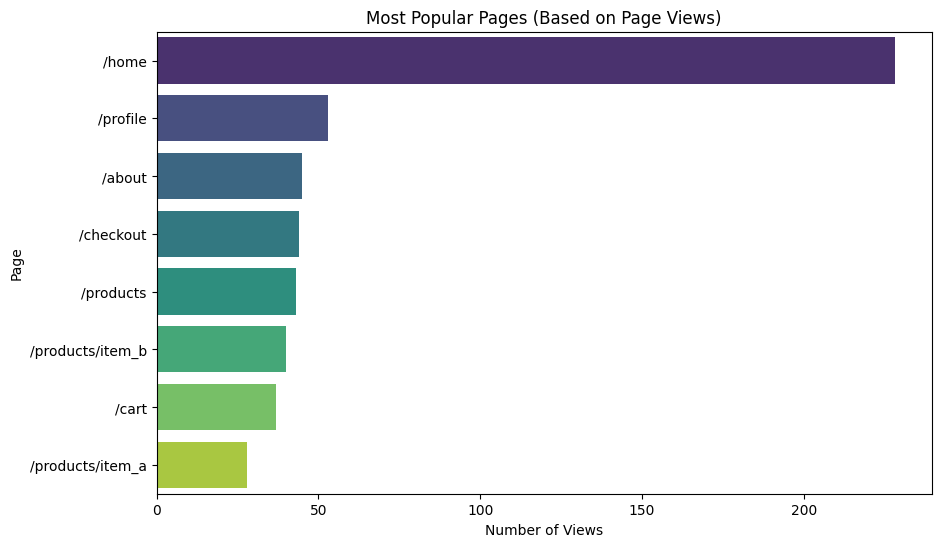

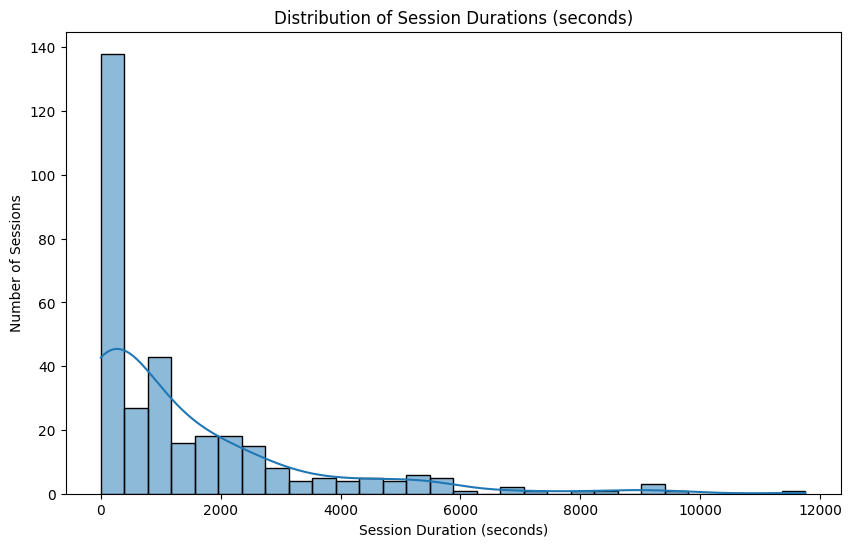

<ipython-input-4-cf213845d12f>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funnel_df['UniqueUsers'], y=funnel_df['Step'], palette='magma')


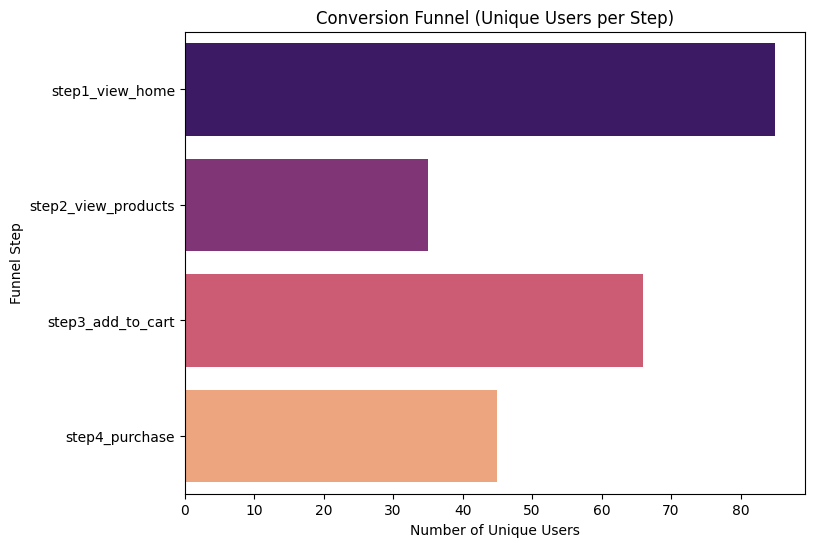

<ipython-input-4-cf213845d12f>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=popular_events.values, y=popular_events.index, palette='rocket')


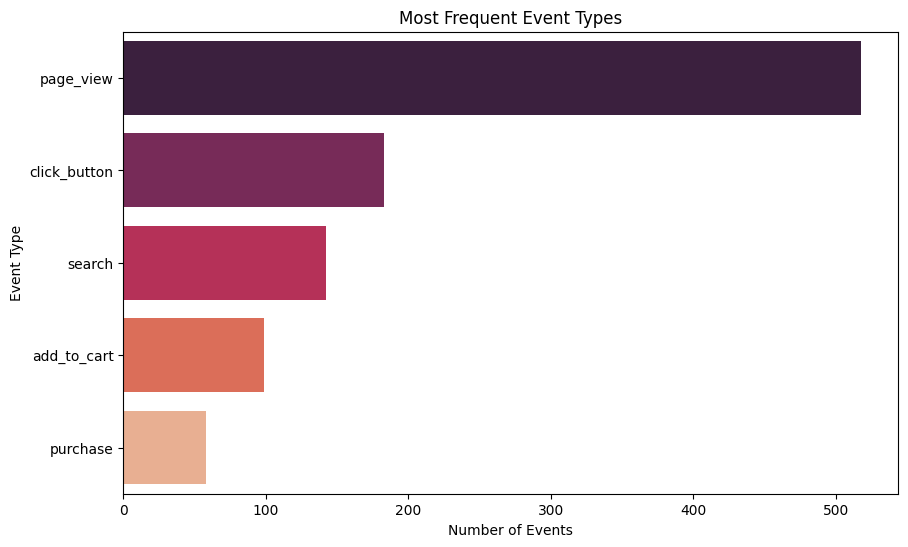

<ipython-input-4-cf213845d12f>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=common_entry_pages.values, y=common_entry_pages.index, palette='cubehelix')


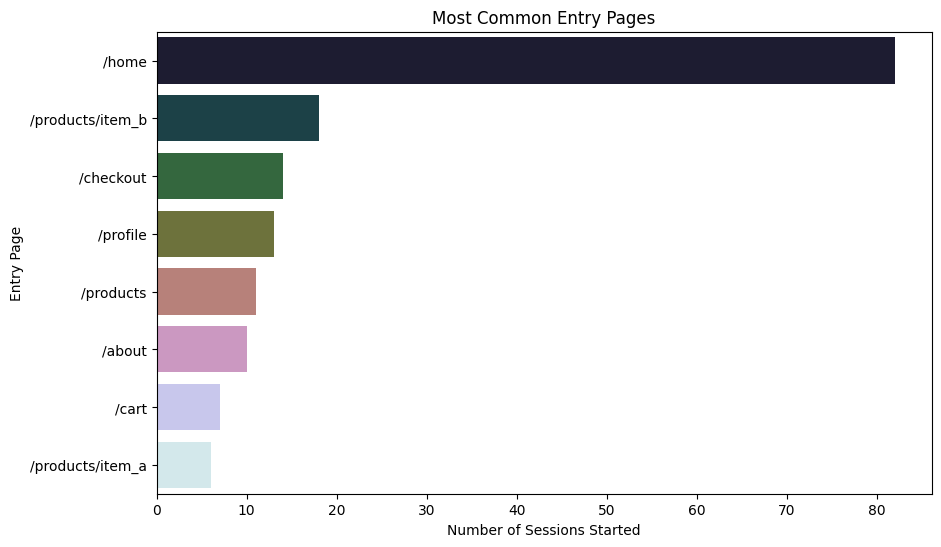

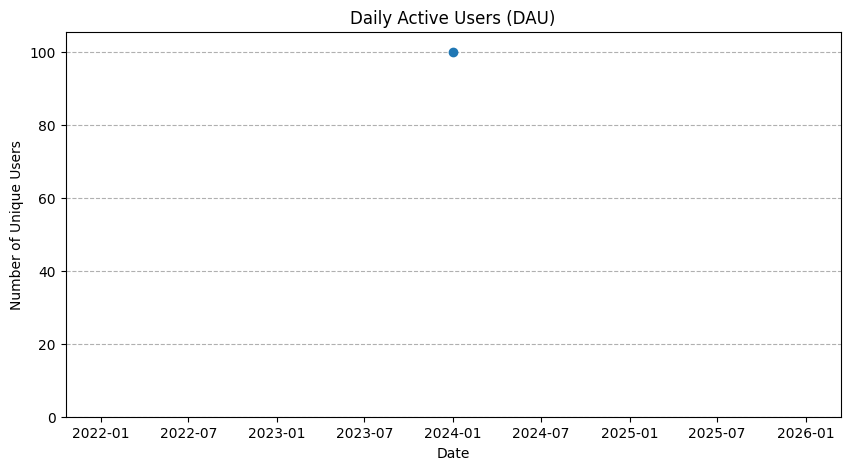

In [4]:
# prompt: visualize the data

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(x=popular_pages.values, y=popular_pages.index, palette='viridis')
plt.title('Most Popular Pages (Based on Page Views)')
plt.xlabel('Number of Views')
plt.ylabel('Page')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(session_durations['duration_seconds'], bins=30, kde=True)
plt.title('Distribution of Session Durations (seconds)')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Number of Sessions')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x=funnel_df['UniqueUsers'], y=funnel_df['Step'], palette='magma')
plt.title('Conversion Funnel (Unique Users per Step)')
plt.xlabel('Number of Unique Users')
plt.ylabel('Funnel Step')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=popular_events.values, y=popular_events.index, palette='rocket')
plt.title('Most Frequent Event Types')
plt.xlabel('Number of Events')
plt.ylabel('Event Type')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=common_entry_pages.values, y=common_entry_pages.index, palette='cubehelix')
plt.title('Most Common Entry Pages')
plt.xlabel('Number of Sessions Started')
plt.ylabel('Entry Page')
plt.show()

plt.figure(figsize=(10, 5))
dau.plot(kind='line', marker='o')
plt.title('Daily Active Users (DAU)')
plt.xlabel('Date')
plt.ylabel('Number of Unique Users')
plt.grid(True, axis='y', linestyle='--')
plt.ylim(bottom=0)
plt.show()
